In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import time
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
df=pd.read_excel(r"../dataset/data.xlsx",sheet_name="Sheet1")
df

,Number of Storeys(NS),Height of Structure(HS),Number of Spans(HSP),Length of Spans (LS),Opening percentage (OP),Masonry wall Stiffeness Et (MS),Period (P)
0,1,3,2,3.0,0,2.25,0.092970
1,1,3,2,3.0,100,2.25,0.159750
2,1,3,2,4.5,0,2.25,0.094770
3,1,3,2,4.5,100,2.25,0.156589
4,1,3,2,6.0,0,2.25,0.106350
...,...,...,...,...,...,...,...
4021,22,66,6,6.0,50,25.00,1.628000
4022,22,66,6,6.0,75,25.00,2.714000
4023,22,66,6,6.0,100,25.00,2.879000
4024,22,66,6,7.5,0,25.00,0.602680


In [3]:
df.shape

(4026, 7)

In [4]:
df.head()

,Number of Storeys(NS),Height of Structure(HS),Number of Spans(HSP),Length of Spans (LS),Opening percentage (OP),Masonry wall Stiffeness Et (MS),Period (P)
0,1,3,2,3.0,0,2.25,0.092970
1,1,3,2,3.0,100,2.25,0.159750
2,1,3,2,4.5,0,2.25,0.094770
3,1,3,2,4.5,100,2.25,0.156589
4,1,3,2,6.0,0,2.25,0.106350


In [5]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df)

normalized_df = pd.DataFrame(normalized_data, columns=df.columns)

print(normalized_df)

      Number of Storeys(NS)  Height of Structure(HS)  Number of Spans(HSP)  \
0                       0.0                      0.0                   0.0   
1                       0.0                      0.0                   0.0   
2                       0.0                      0.0                   0.0   
3                       0.0                      0.0                   0.0   
4                       0.0                      0.0                   0.0   
...                     ...                      ...                   ...   
4021                    1.0                      1.0                   1.0   
4022                    1.0                      1.0                   1.0   
4023                    1.0                      1.0                   1.0   
4024                    1.0                      1.0                   1.0   
4025                    1.0                      1.0                   1.0   

      Length of Spans (LS)  Opening percentage (OP)  \
0       

In [6]:
normalized_df.keys()

Index(['Number of Storeys(NS)', 'Height of Structure(HS)',
       'Number of Spans(HSP)', 'Length of Spans (LS)',
       'Opening percentage (OP)', 'Masonry wall Stiffeness Et (MS)',
       'Period (P)'],
      dtype='object')

In [7]:
X=normalized_df.drop("Period (P)" ,axis=1)

In [8]:
y=normalized_df["Period (P)"]

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=99)

# NGBoost

In [11]:
from ngboost import NGBRegressor

In [12]:
from sklearn.model_selection import KFold,cross_validate
from bayes_opt import BayesianOptimization
from hyperopt import hp,fmin,tpe,Trials,partial
from hyperopt.early_stop import no_progress_loss
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
import optuna.integration.lightgbm as oplg

In [13]:
param_grid_simple={'n_estimators':hp.quniform('n_estimators',1000,5000,50),
                   'learning_rate': hp.uniform('learning_rate', 0.001, 0.999),
                  }

In [14]:
def hyperopt_objective(params):
    model=NGBRegressor(n_estimators=int(params['n_estimators'])
              ,learning_rate=params['learning_rate']                     
              ,random_state=99)
    
    cv=KFold(n_splits=10,shuffle=True,random_state=99)
    validate_loss=cross_validate(model,X_train,y_train
                                   ,cv=cv
                                   ,scoring='neg_root_mean_squared_error'
                                   ,n_jobs=-1
                                   ,error_score='raise')
    
    return np.mean(abs(validate_loss['test_score']))

In [15]:
def param_hyperopt(max_evals=100):
    trials=Trials()
    
    early_stop_fn=no_progress_loss(100) 
    params_best=fmin(hyperopt_objective 
                     ,space=param_grid_simple 
                     ,algo=tpe.suggest 
                     ,max_evals=max_evals 
                     ,trials=trials 
                     ,early_stop_fn=early_stop_fn 
                    )
    
    print('best parmas:',params_best)
    return params_best,trials

In [16]:
def hyperopt_validation(params):
    model=NGBRegressor(n_estimators=int(params['n_estimators'])
              ,learning_rate=params['learning_rate']                     
              ,random_state=99)
        
    cv=KFold(n_splits=10,shuffle=True,random_state=99)
    validate_loss=cross_validate(model,X_train,y_train
                                   ,cv=cv
                                   ,scoring='neg_root_mean_squared_error'
                                   ,n_jobs=-1
                                  )
    
    return np.mean(abs(validate_loss['test_score']))


In [17]:
# Start time
start_time = time.time()

params_best, trials = param_hyperopt(100)

hyperopt_validation(params_best)

trials.trials[0]

trials.losses()[:10]
# End time
end_time = time.time()
# Calculate total time
total_time = end_time - start_time
print("Total time taken: ", total_time)

100%|██████████| 100/100 [4:14:37<00:00, 152.78s/trial, best loss: 0.008317129990260661]  
best parmas: {'learning_rate': 0.449719980517915, 'n_estimators': 4800.0}
Total time taken:  15392.69148349762


In [18]:
from ngboost import NGBRegressor
params_best['n_estimators'] = int(params_best['n_estimators'])
nbr_reg= NGBRegressor(**params_best )
nbr_reg.fit(X_train, y_train)

[iter 0] loss=-0.0899 val_loss=0.0000 scale=1.0000 norm=0.4985
[iter 100] loss=-3.1002 val_loss=0.0000 scale=1.0000 norm=0.4118
[iter 200] loss=-3.4240 val_loss=0.0000 scale=0.0039 norm=0.0016
[iter 300] loss=-3.6092 val_loss=0.0000 scale=0.0039 norm=0.0016
[iter 400] loss=-3.7167 val_loss=0.0000 scale=0.0039 norm=0.0016
[iter 500] loss=-3.7210 val_loss=0.0000 scale=0.0039 norm=0.0016
[iter 600] loss=-3.7806 val_loss=0.0000 scale=1.0000 norm=0.4164
[iter 700] loss=-3.8007 val_loss=0.0000 scale=0.0039 norm=0.0016
[iter 800] loss=-3.8137 val_loss=0.0000 scale=0.0039 norm=0.0016
[iter 900] loss=-3.8173 val_loss=0.0000 scale=0.0039 norm=0.0016
[iter 1000] loss=-3.8302 val_loss=0.0000 scale=0.0039 norm=0.0016
[iter 1100] loss=-3.8619 val_loss=0.0000 scale=0.5000 norm=0.2066
[iter 1200] loss=-3.8748 val_loss=0.0000 scale=0.0078 norm=0.0032
[iter 1300] loss=-3.8888 val_loss=0.0000 scale=0.0078 norm=0.0032
[iter 1400] loss=-3.8966 val_loss=0.0000 scale=0.0039 norm=0.0016
[iter 1500] loss=-3.89

NGBRegressor(learning_rate=0.4497, n_estimators=4800,
             random_state=RandomState(MT19937) at 0x27867C5CF40)

In [19]:
y_pred= nbr_reg.predict(X_test)
y_pred1=nbr_reg.predict(X_val)
y_pred2=nbr_reg.predict(X_train)

In [20]:
print("mean_absolute_error:", mean_absolute_error(y_val, y_pred1))
print("mean_squared_error:", mean_squared_error(y_val, y_pred1))
print("rmse:", sqrt(mean_squared_error(y_val, y_pred1)))
print("r2 score:", r2_score(y_val, y_pred1))

mean_absolute_error: 0.005446560485250744
mean_squared_error: 6.049810107459944e-05
rmse: 0.007778052524546195
r2 score: 0.9987866116110999


In [21]:
print("mean_absolute_error:", mean_absolute_error(y_train, y_pred2))
print("mean_squared_error:", mean_squared_error(y_train, y_pred2))
print("rmse:", sqrt(mean_squared_error(y_train, y_pred2)))
print("r2 score:", r2_score(y_train, y_pred2))

mean_absolute_error: 0.004087169310673714
mean_squared_error: 3.35555533284824e-05
rmse: 0.005792715540097097
r2 score: 0.9993140069351024


In [22]:
print("mean_absolute_error:", mean_absolute_error(y_test, y_pred))
print("mean_squared_error:", mean_squared_error(y_test, y_pred))
print("rmse:", sqrt(mean_squared_error(y_test, y_pred)))
print("r2 score:", r2_score(y_test, y_pred))

mean_absolute_error: 0.00563432932328101
mean_squared_error: 6.81898232511719e-05
rmse: 0.00825771295524202
r2 score: 0.9986689646698611


In [29]:
from yellowbrick.regressor import PredictionError

D:\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(


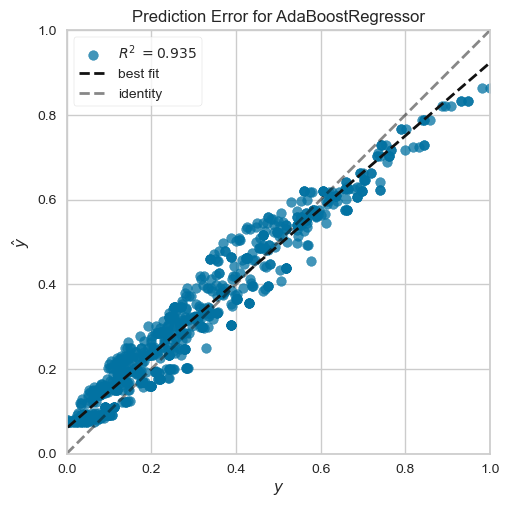

<Axes: title={'center': 'Prediction Error for AdaBoostRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [30]:
visualizer = PredictionError(ada_reg)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()